Floyd A. Brown

CSCI470 - Computer Vision and Image Analysis

Wilmington University

Dr. Angela Patterson

April 27th, 2025

Week 7 - Final Project - Build a CNN Model that Classifies Plant Seedlings into Twelve Categories





In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import (Flatten, Dense, Dropout)

Load Datasets


In [ ]:
plantimages = np.load('images.npy') #npy is file type for numpy arrays
plantlabels = pd.read_csv('Labels.csv')

Create the training and test data set

Print Shape and proportion of the Data

In [ ]:
plantclassproportions = plantlabels.value_counts()
'''plantimages has a shape of (4750, 128, 128, 3),
indicating it contains 4750 images, each with dimensions
128x128 and 3 color channels.
'''
print("Plant Image \"images.npy\" Dataset Shape\n", plantimages.shape)
print("Plant Lables \"Labels.csv\" Dataset Shape\n", plantlabels.shape)
print("Proportion of plant classes:\n", plantclassproportions)

Plant Image "images.npy" Dataset Shape
 (4750, 128, 128, 3)
Plant Lables "Labels.csv" Dataset Shape
 (4750, 1)
Proportion of plant classes:
 Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: count, dtype: int64


# **Exploratory Data Analysis (EDA) to obtain insights on image dataset**
EDA of the viewed image shows closeups of bright, green leafy seedlings with two or three leaves, against a background of dark pebbles.

Each sampled sample has the same normalized properties of size 49512 and shape 128x128 dimension which is expected as this is a established dataset of plant species provided by Aarhus University Signal Processing froup and the University of Southern Denmark.

If this was a custom dataset build as needed, we could have conducted additional EDA to code further analysis to learn more about the comparative properties of the sample for additional tuning and normalization as well as to account for outliers by (1) performing pixel value analys to understand the contrast, brightness, color (2) Image collection analysis - to visualize aggregate statistics on average size, standard deviation, etc.   

The dataset is not balanced with each species having a similar number of samples. There are more Lose Silky-bent plants, at more than 650 samples, than any other plant, closely followed by approximately 600 Chick Weed. There are four plants close to or greater than 500 samples, while there are seven plants with less than 400 samples.

Plot sample images from each class with labels

Plot the count of each category to understand class distribution

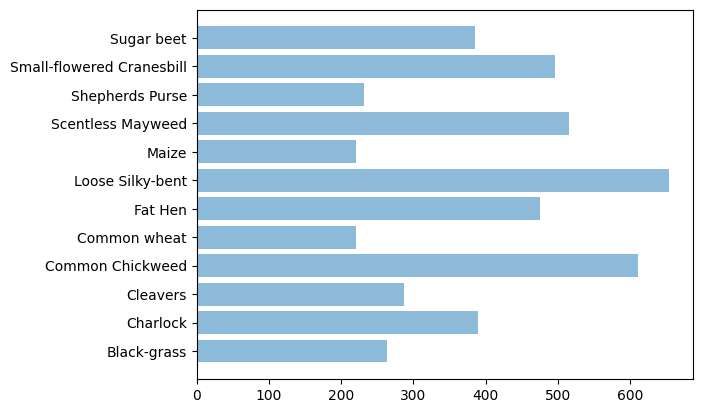

In [ ]:
plantclasses, plantdist = np.unique(plantlabels, return_counts=True)
PLANT_CLASSES = len(plantclasses)
plt.barh(plantclasses, plantdist, align='center', alpha=0.5)
plt.show()

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:70


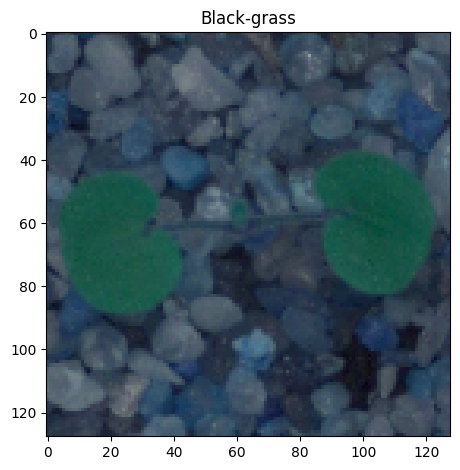

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:65


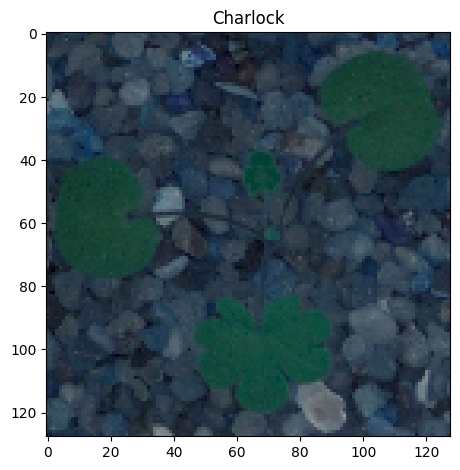

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:70


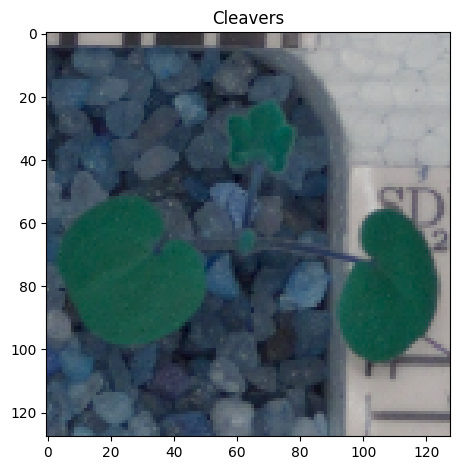

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:63


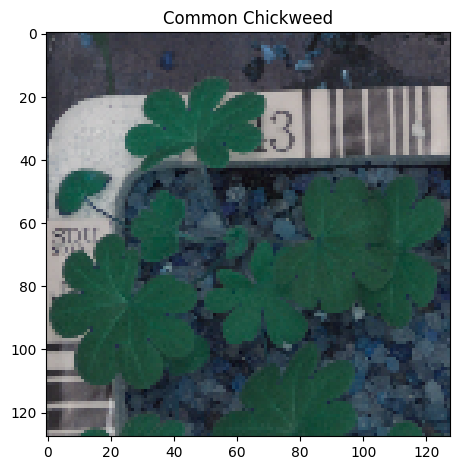

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:86


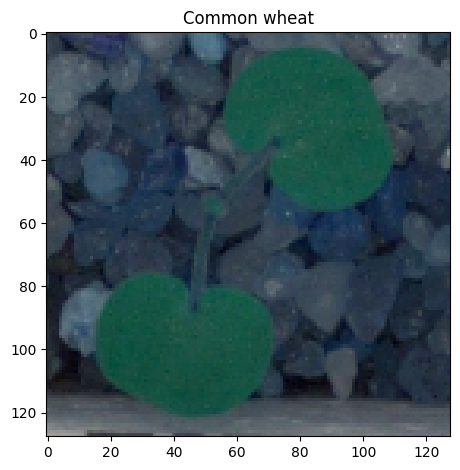

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:72


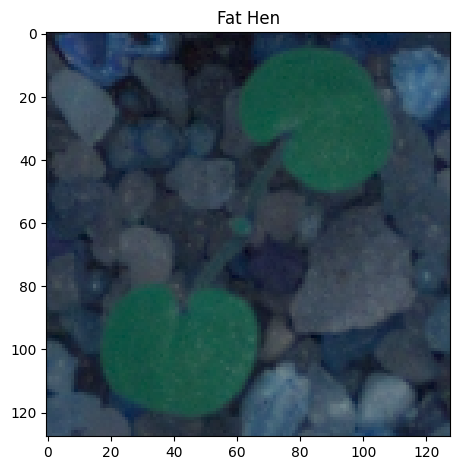

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:74


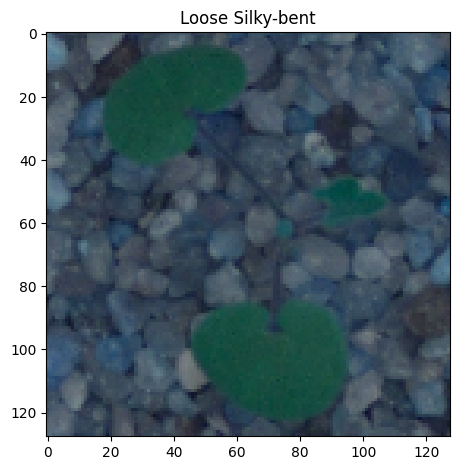

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:67


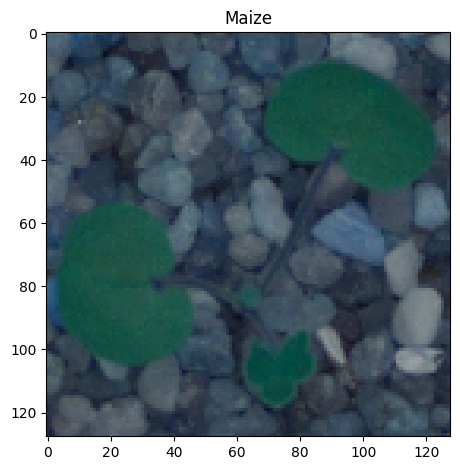

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:76


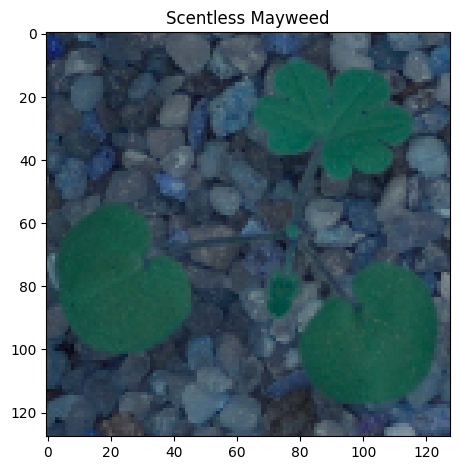

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:70


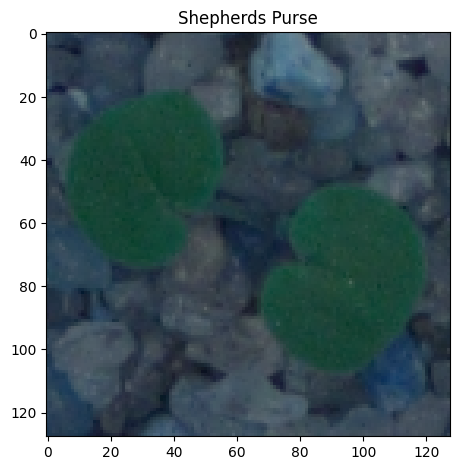

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:58


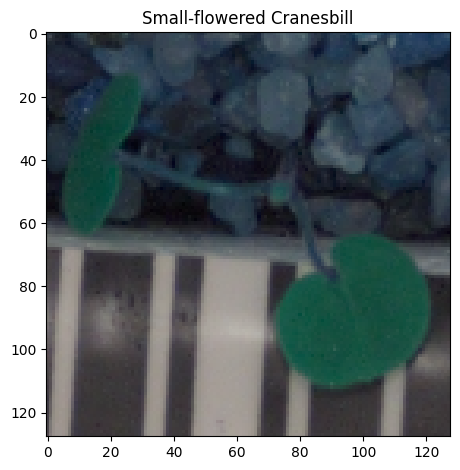

Seedling image size:49152
Seedling image shape:(128, 128, 3)
Seedling image format:uint8
Seedling image mode:66


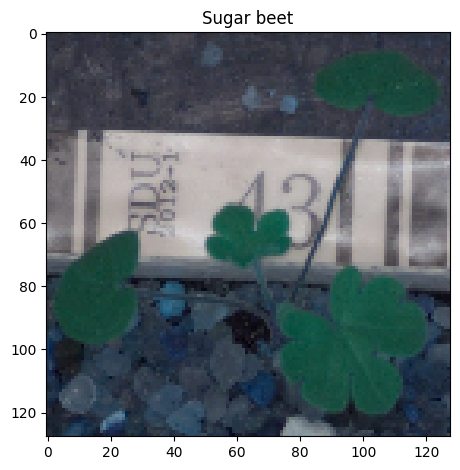

In [ ]:
#print first image for each unique class
#num_plantimages = len(plantimages)
image_sample=[]
for i in range(len(plantclasses)):
  #print(np.unique(plantclasses))
  if np.unique(plantclasses[i]):
    print(f"Seedling image size:{plantimages[i].size}")
    print(f"Seedling image shape:{plantimages[i].shape}")
    print(f"Seedling image format:{plantimages[i].dtype}")
    print(f"Seedling image mode:{np.bincount(plantimages[i].ravel()).argmax()}")
    plt.imshow(plantimages[i], cmap='gray')
    plt.title(plantclasses[i])
    #plt.show()
    image_sample.append(plantimages[i])

  plt.tight_layout()
  plt.show()

# Data Preprocessing - Clean Data

**Noise Removal** - Apply Gaussian Blurring to remove noise from the images

**Normalization** - normalize images to a range of 0 -1

**Visualization** - plot images before and after processing

**Split Data** - Split data into training and testing sets

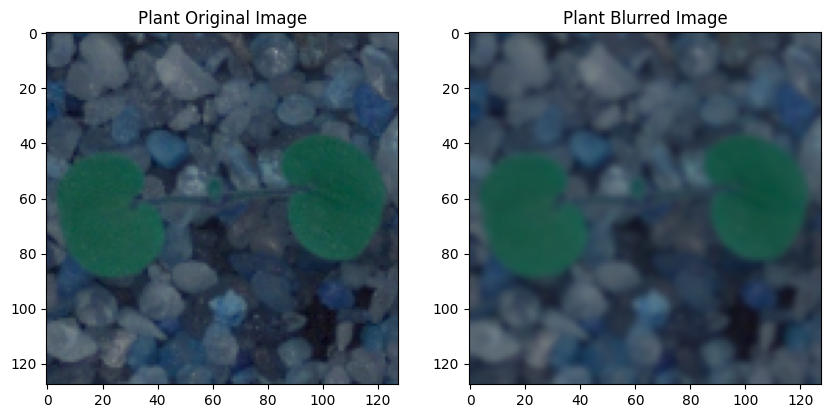

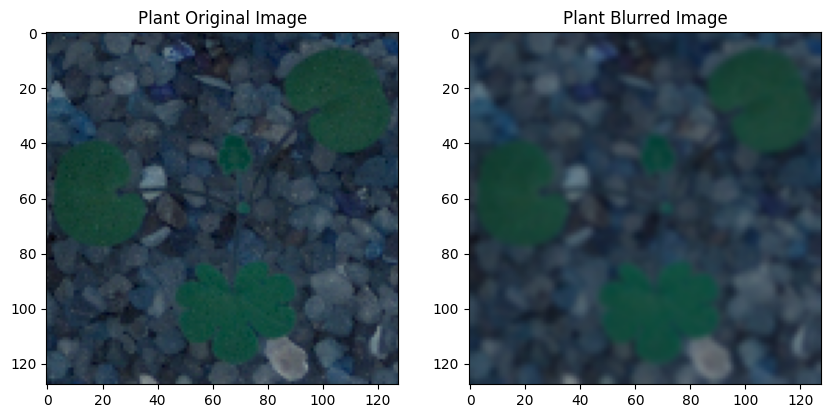

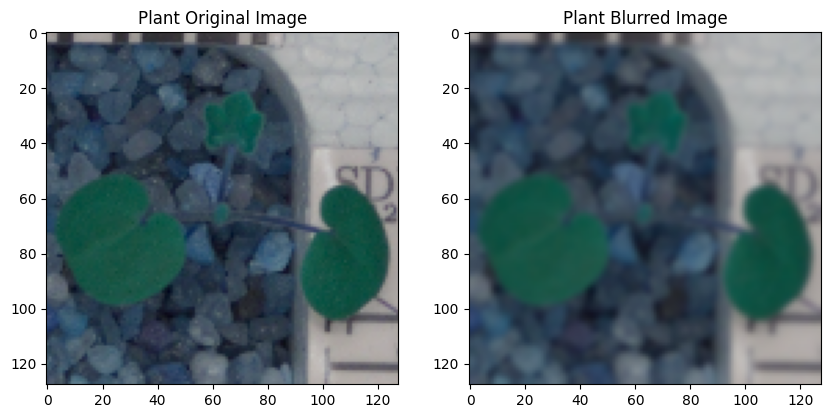

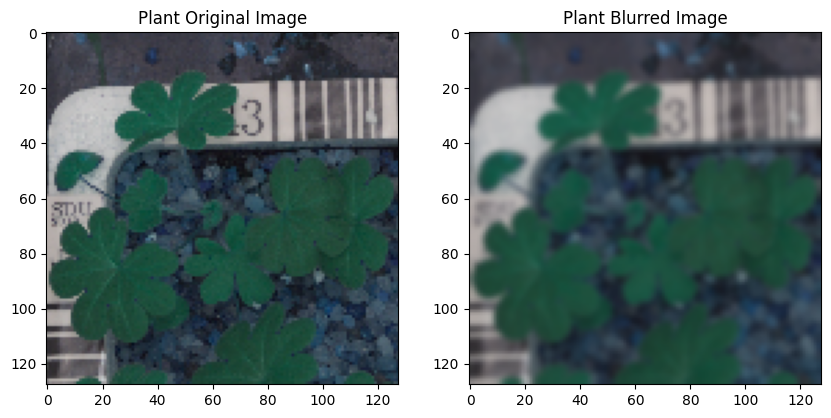

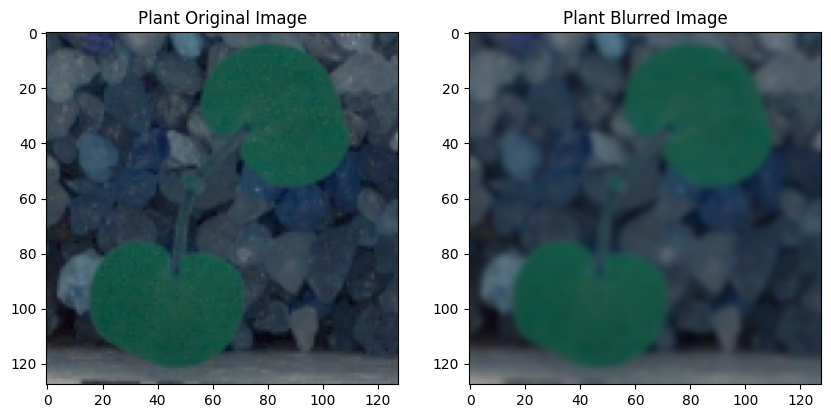

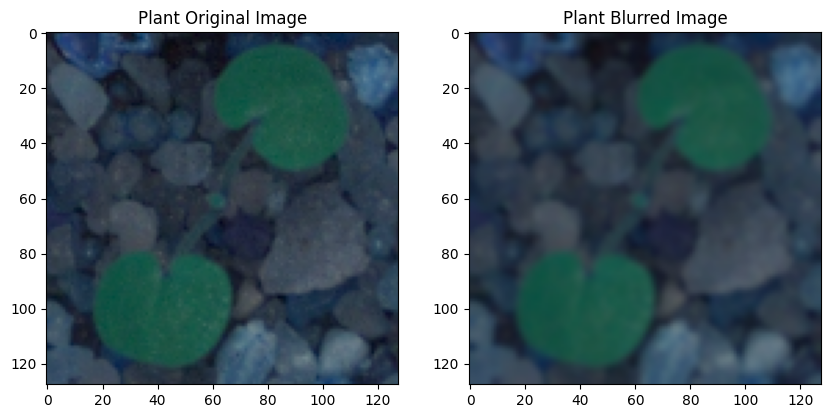

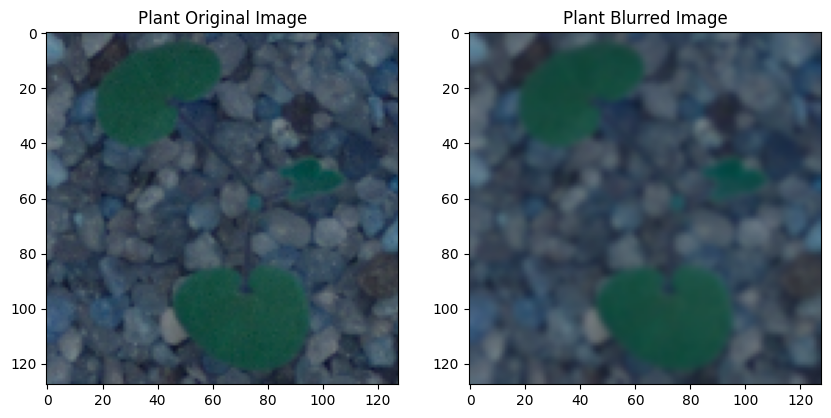

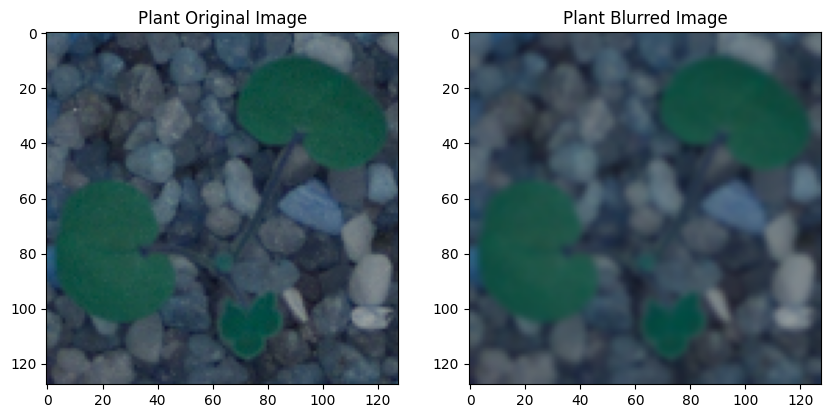

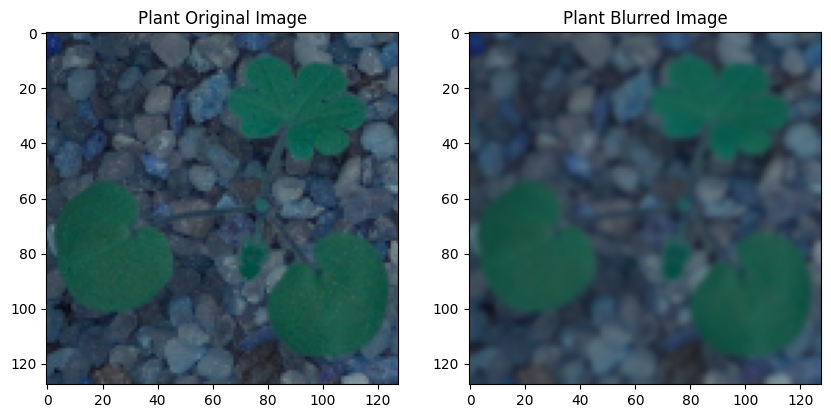

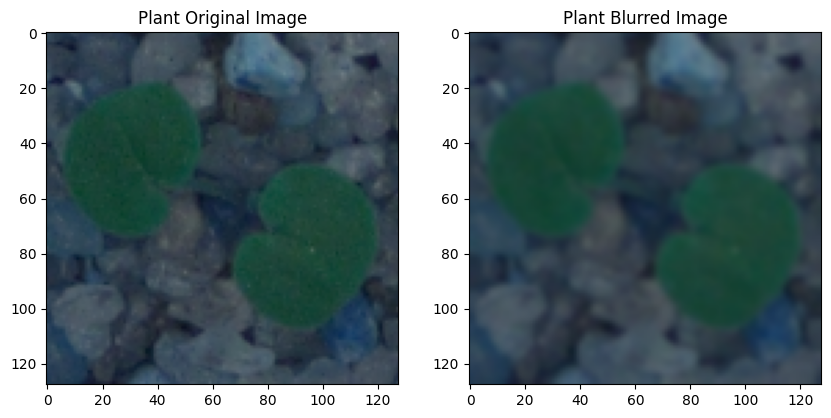

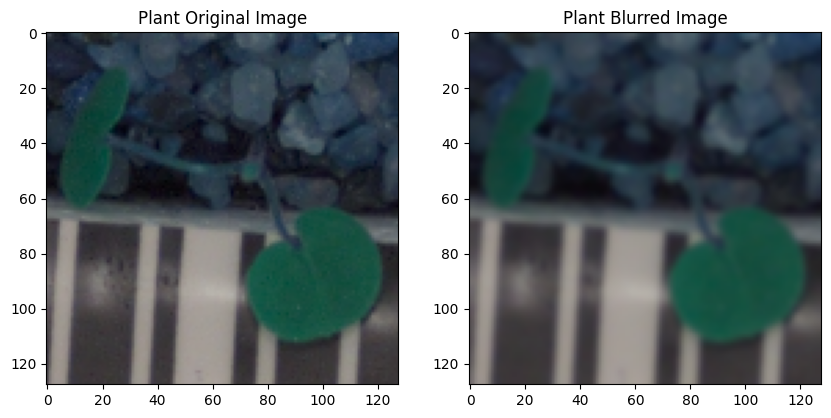

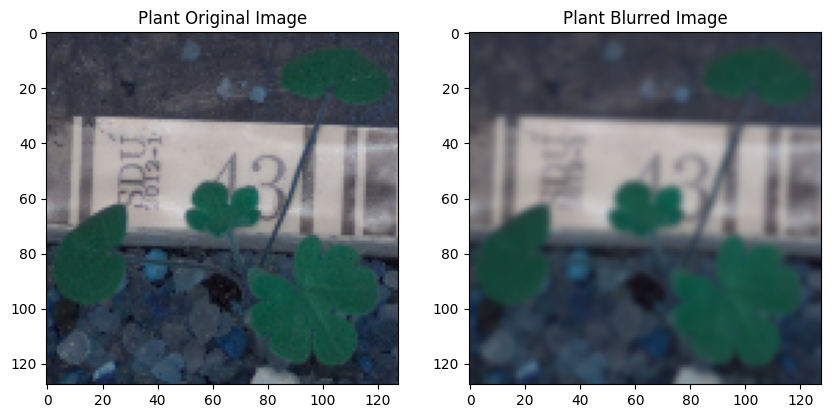

In [ ]:
'''
**Noise Removal** - Apply Gaussian Blurring to remove noise from the images
'''
plantimages_blurred = []
for image in plantimages:
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    plantimages_blurred.append(blurred_image)
plantimages_blurred = np.array(plantimages_blurred)

#display sample of an original and blurred image from
#the dataset of plant images
for i in range(len(plantclasses)):
  if np.unique(plantclasses[i]):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(plantimages[i])
    plt.title('Plant Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(plantimages_blurred[i])
    plt.title('Plant Blurred Image')
    plt.show()



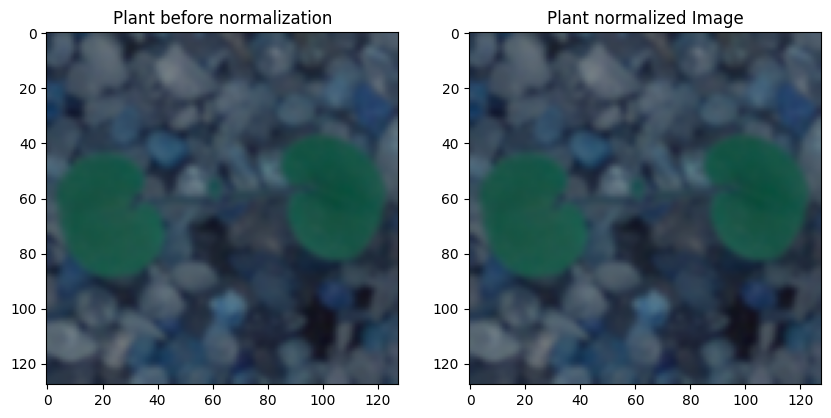

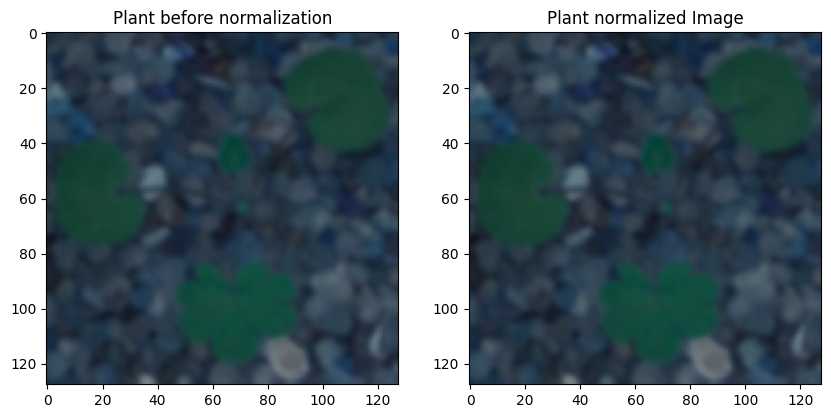

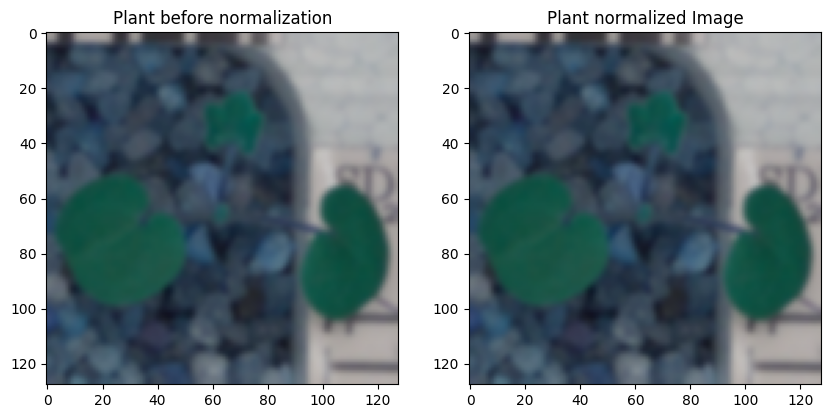

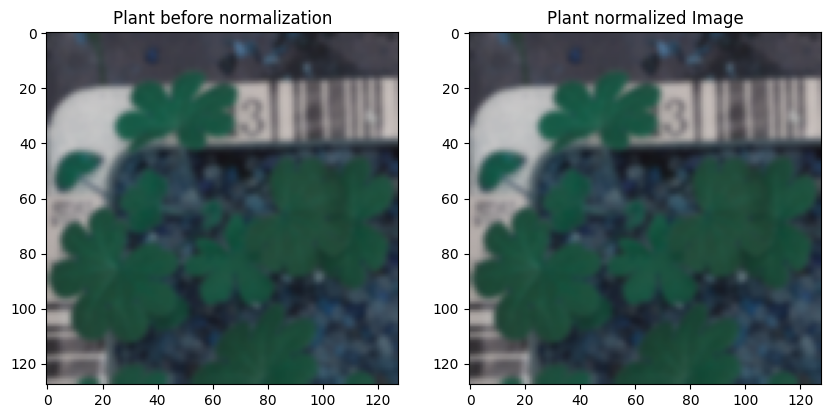

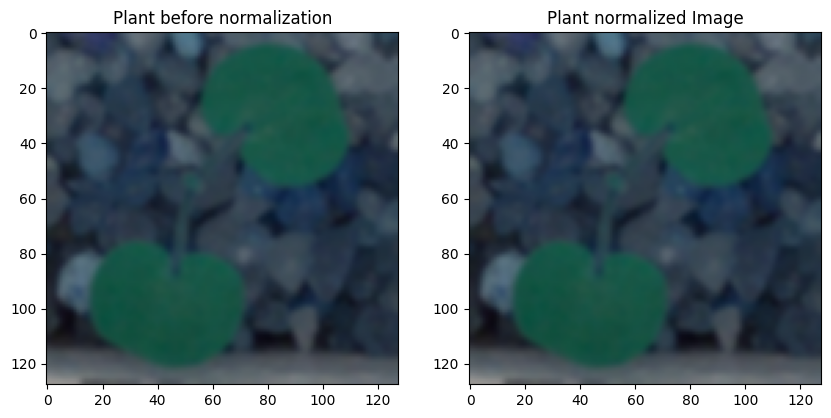

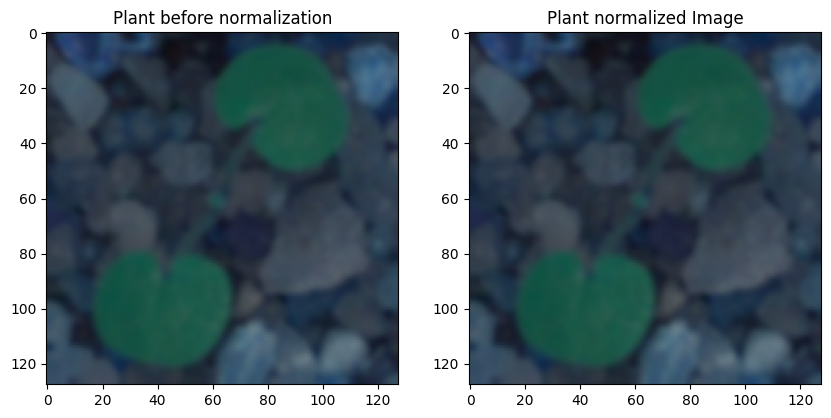

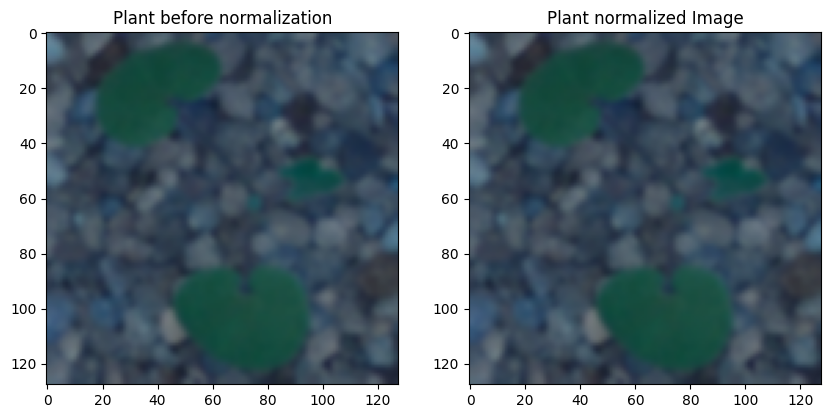

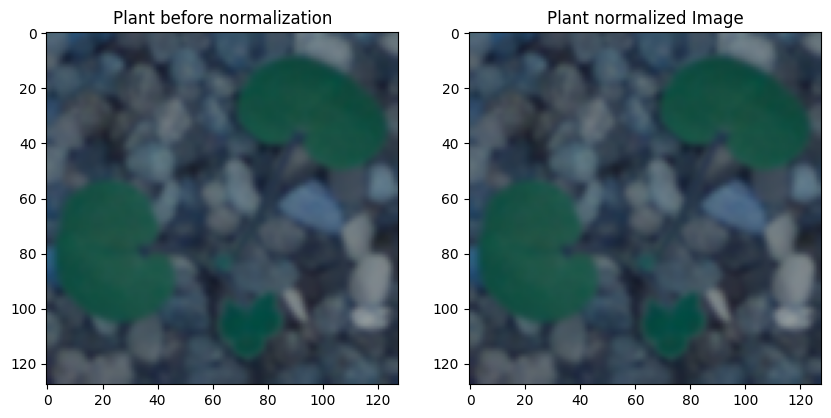

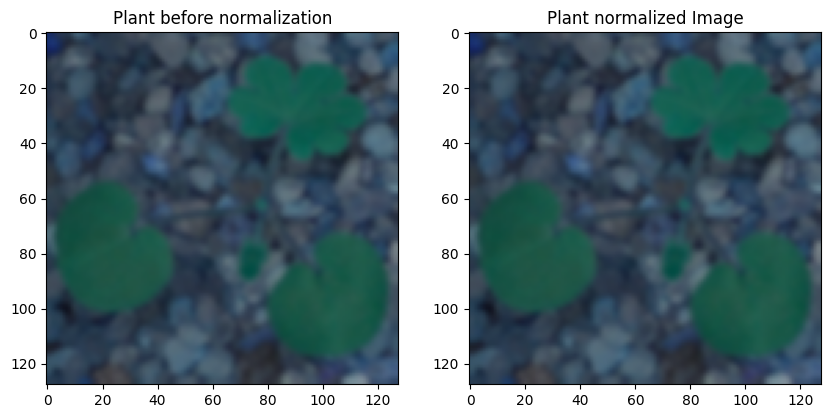

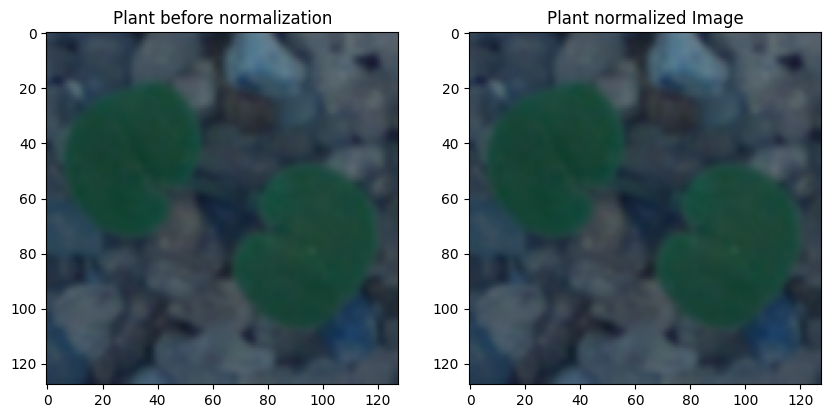

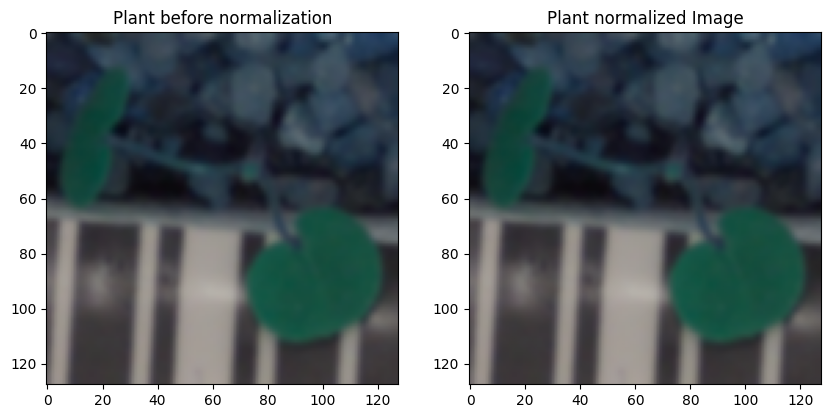

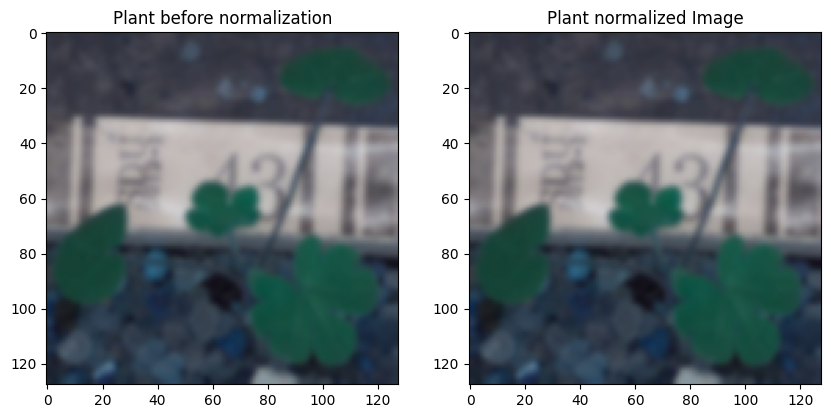

In [ ]:
'''
Normalization - normalize images to a range of 0-1
'''
def normalize_plantimages(plantimages_blurred):
    normalized_plantimages = []#initialize empty plant list
    for image in plantimages_blurred:
        normalized_plantimage = image / 255.0
        normalized_plantimages.append(normalized_plantimage)
    normalized_plantimages = np.array(normalized_plantimages)
    return normalized_plantimages

normalized_plantimages = normalize_plantimages(plantimages_blurred)

#Visualization - plot images before and after processing
for i in range(len(plantclasses)):
  if np.unique(plantclasses[i]):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(plantimages_blurred[i])
    plt.title('Plant before normalization')
    plt.subplot(1, 2, 2)
    plt.imshow(normalized_plantimages[i])
    plt.title('Plant normalized Image')
    plt.show()


# Split Data into Training and Test set

In [ ]:
'''
Split Data - Split data into training and testing sets
'''
plantimage_train, plantimage_test, plantlabel_train, plantlabel_test = train_test_split(normalized_plantimages, plantlabels, test_size=0.2, random_state=42)
print("plantimage_train shape:", plantimage_train.shape)
print("plantimage_test shape:", plantimage_test.shape)
print("plantlabel_train shape:", plantlabel_train.shape)
print("plantlabel_test shape:", plantlabel_test.shape)


plantimage_train shape: (3800, 128, 128, 3)
plantimage_test shape: (950, 128, 128, 3)
plantlabel_train shape: (3800, 1)
plantlabel_test shape: (950, 1)


# Make Data Compatible
Use One-Hot Encoding to convert lables for classification and ensure data is comparable with Keras.

The plant classification is quanlitative variables. One-hot encoding is to ensure values that do not apply to Plant labelings are zero, we create as many features as classes in the feature. Each feature will contain 1 only if it applies or appears to the data otherwise the value is 0. Keras enables deep learning model architecture so we ensure the data shape is comparable to Keras.


In [ ]:
#convert labels to one hot vectors for multiclass classification
#reshape plantlabels, for traning and testing categories, ito a 2D array
plantlabel_train = plantlabel_train.values.reshape(-1, 1)
plantlabel_test = plantlabel_test.values.reshape(-1, 1)

#initialize OneHotEncoder
onehotencoder = OneHotEncoder()

#fit the encoder to the labels and transform them
plantlabel_train_onehot = onehotencoder.fit_transform(plantlabel_train).toarray()
plantlabel_test_onehot = onehotencoder.transform(plantlabel_test).toarray()

#print shapes of one-hot encoded labels
print("plantlabel_train_onehot shape:", plantlabel_train_onehot.shape)
print("plantlabel_test_onehot shape:", plantlabel_test_onehot.shape)

plantlabel_train_onehot shape: (3800, 12)
plantlabel_test_onehot shape: (950, 12)


# CNN Model Building -
Building the model with appropriate layers
Convolutional layers transform the original image using various kinds of filtering. Each layer finds specific patterns in the image (shapes and colors).

Bumber of classes:{} 12
Plant Image and Class:
 ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Plant Image Distribution:
 [263 390 287 611 221 475 654 221 516 231 496 385]


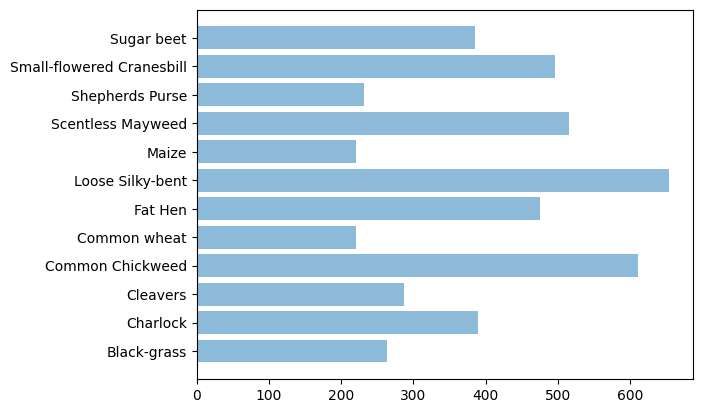

In [ ]:
#check the distribution of classes to ensure Neural Network for
#multiclass training is not skewed to learn the most populated class
plantimage_andtest, plantimage_dist = np.unique(np.concatenate([plantlabel_train,plantlabel_test]), return_counts=True)
PLANT_CLASSES = len(plantimage_andtest)
print("Bumber of classes:{}",format(PLANT_CLASSES))

print("Plant Image and Class:\n", plantimage_andtest)
print("Plant Image Distribution:\n", plantimage_dist)
#Use plt.harh so that class labels do not overlap in the horizontal versue vertical bar graph
plt.barh(plantimage_andtest, plantimage_dist, align='center', alpha=0.5)
plt.show()


# Solution to unbalanced class in multiclss neural network training

Create a class weight that is a ratio based on the frequency of classes that the neural network use to increase the impact it receives from infrequent examples and minimize impact of frequent examples

In [ ]:
'''
Improve Neural Network training model by create a class weight that is a ratio based on the frequency of classes
'''
#plantclass_weight = {c:plantimage_dist[c]/np.sum(plantimage_dist) for c in plantimage_andtest}
plantclass_weight = {plantimage_andtest[i]: plantimage_dist[i]/np.sum(plantimage_dist) for i in range(len(plantimage_andtest))}
print("Plant Class Weight:\n", plantclass_weight)


Plant Class Weight:
 {'Black-grass': np.float64(0.05536842105263158), 'Charlock': np.float64(0.08210526315789474), 'Cleavers': np.float64(0.060421052631578945), 'Common Chickweed': np.float64(0.12863157894736843), 'Common wheat': np.float64(0.046526315789473686), 'Fat Hen': np.float64(0.1), 'Loose Silky-bent': np.float64(0.1376842105263158), 'Maize': np.float64(0.046526315789473686), 'Scentless Mayweed': np.float64(0.10863157894736843), 'Shepherds Purse': np.float64(0.04863157894736842), 'Small-flowered Cranesbill': np.float64(0.10442105263157894), 'Sugar beet': np.float64(0.08105263157894736)}


# Image Generator
Image generator retrieves image data in batches for training and validation

In [ ]:
#Generator - image already rescaled during normalization so will not rescale for ImageDataGenerator
batch_size = 256
tgen=ImageDataGenerator(rotation_range=5, horizontal_flip=True, vertical_flip=True)
train_generator = tgen.flow(plantimage_train, plantlabel_train_onehot, batch_size=batch_size)
vgen=ImageDataGenerator()
validation_generator = vgen.flow(plantimage_test, plantlabel_test_onehot, batch_size=batch_size)

# Build the Convolutional Neural Network

In [ ]:
def plantclass_cnn():
  plantmodel = Sequential()
  #CNN concolution with 32 channel, working with a kernel of size (3,3)
  plantmodel.add(Conv2D(32, (3, 3),  input_shape=(128, 128, 3),activation='relu'))
  plantmodel.add(MaxPooling2D((2, 2)))
  #CNN concolution with 64 channel, working with a kernel of size (3,3)
  plantmodel.add(Conv2D(64, (3, 3), activation='relu'))
  plantmodel.add(MaxPooling2D((2, 2)))
  #CNN concolution with 768 channel, working with a kernel of size (3,3)
  plantmodel.add(Conv2D(768, (3, 3), activation='relu'))
  plantmodel.add(MaxPooling2D((2, 2)))
  plantmodel.add(Flatten())

  #plantmodel.add(Dense(128, activation='relu')) #Dense layer of 768 after convolutions
  #Dropout regularizes the layer and drops 50 percent of the nodes and softmax activiates it
  #meaning sum of the output probabilities of all classes sum to 100 percemt
  plantmodel.add(Dropout(0.5))
  plantmodel.add(Dense(PLANT_CLASSES, activation='softmax'))
  return plantmodel

#Train the model
plantmodel = plantclass_cnn()
plantmodel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
plantmodel.summary()





Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 768)    │       443,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 768)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │     1,806,348 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,876 (8.66 MB)

 Trainable params: 2,268,876 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training
Plot Training History
Visualization of training and validation accuracy and loss
-Epoch is passing through the entire dataset through the neural network one time
-batch is part of the dataset, This means breaking the dataset into chunks, i.e. 300 chunks
-Note that the model takes long time to run through each epoch. As such using smaller epoch size and a larger batch size as ***increasing the epoch size and decreasing the batch size will increase the accuracy of the model***

In [ ]:
history = plantmodel.fit(train_generator,
                                   steps_per_epoch=len(plantimage_train) //batch_size,
                                   validation_data=validation_generator,
                                   validation_steps=len(plantimage_test) //batch_size,
                                   class_weight=plantclass_weight,
                                   epochs=30,
                                   verbose = 2
                                   )

#plt.plot(history.history['accuracy']) plt.plot(history.history['val_accuracy'])
#plt.title('Model Accuracy') plt.ylabel('Accuracy') plt.xlabel('Epoch') plt.legend(['Train', 'Validation'], loc='upper left') plt.show()
#plt.plot(history.history['loss']) plt.plot(history.history['val_loss']) plt.title('Model Loss') plt.ylabel('Loss') plt.xlabel('Epoch') plt.legend(['Train', 'Validation'], loc='upper left') plt.show()


Epoch 1/30
14/14 - 287s - 20s/step - accuracy: 0.1705 - loss: 2.4061 - val_accuracy: 0.2865 - val_loss: 2.1291
Epoch 2/30
14/14 - 32s - 2s/step - accuracy: 0.3194 - loss: 2.1346 - val_accuracy: 0.2943 - val_loss: 2.0664
Epoch 3/30
14/14 - 322s - 23s/step - accuracy: 0.3781 - loss: 1.8020 - val_accuracy: 0.4505 - val_loss: 1.5987
Epoch 4/30
14/14 - 41s - 3s/step - accuracy: 0.3984 - loss: 1.6816 - val_accuracy: 0.4440 - val_loss: 1.6189
Epoch 5/30
14/14 - 323s - 23s/step - accuracy: 0.4732 - loss: 1.5092 - val_accuracy: 0.5339 - val_loss: 1.4561
Epoch 6/30
14/14 - 41s - 3s/step - accuracy: 0.5391 - loss: 1.3830 - val_accuracy: 0.5365 - val_loss: 1.3985
Epoch 7/30
14/14 - 321s - 23s/step - accuracy: 0.5387 - loss: 1.3428 - val_accuracy: 0.5495 - val_loss: 1.2931
Epoch 8/30
14/14 - 41s - 3s/step - accuracy: 0.5703 - loss: 1.2994 - val_accuracy: 0.5469 - val_loss: 1.3015
Epoch 9/30
14/14 - 322s - 23s/step - accuracy: 0.5894 - loss: 1.2420 - val_accuracy: 0.5898 - val_loss: 1.2407
Epoch 10/

# Model Performance Evaluation


*   Evaluation of the model on the test using various
*   Confusion Matrix - Plot the confusion matrix for model prediction

Best validation accuracy: 2.129


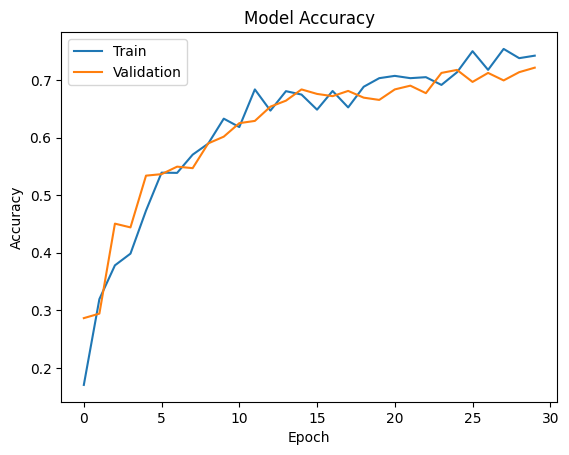

In [ ]:
'''
Best valuation accuracy
Big changes in augmentation requires more epochs for more accurate model.
Note of how the validation accuracy responded during training
'''
print("Best validation accuracy: {:0.3f}".format(np.max(history.history['val_loss'])))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Conclusion and Key Takeaways
Summarization of findings

The valuation accuracy was not as tight with training and testing data as intended. Building a working learning model is a skill and an art that takes practice to gain improvement. In any event, this project proves, according to the course observation, that a difference may exist between the accuracy of the validation data and the training data because training data is complete and variable than the validation data which is a subset of the training data. The type of image augmentation applied to prevent overfitting also accounts for significant difference in performance between training and test results. Next steps for improving the learning model are to look at normalization techniques used, adjust the dense layer settings, or dropout rate.


In addition, only 5 epochs were initially executed versus the improved results expected from running 100 epochs. There was hesitation to run more epochs as the plantmodel summary showed over 19 million parameters for "...dense_2 (Dense) layer..". There was another error earlier that caused the learning model to crash due to an error in the code that caused execution to exceed RAM resources dedicated to the session.

To minimize the error of that recurrence the number of epochs were minimized. The expectation is that additional epochs may improve the accuracy and comparative relationship between the graphed training and validation errors. The text also highlighted that 30 epochs is a better baseline to reach the performance levels of the model (98 percent accuracy). After removing this erroneous line for "...dense_2 layer..." and re-run the code with 30 epochs we observed improved results in model accuracy. The testing curve fell below the training curve at several points, so training did not reflect overfit though may be underfitting which may be improved with the dropout rate or bluring or other adjustments to the test data.


Thank you